# Exploration of geographically weighted random forest classification modelling

In [1]:
import pandas as pd
import geopandas as gpd
from libpysal import graph
from sklearn.ensemble import RandomForestClassifier
from geodatasets import get_path
from joblib import Parallel, delayed
from typing import Hashable, Callable

Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr"))

It is in the geographic coords in the  US and we need to work with distances. Re-project and use only points as the graph builder will require points anyway.

In [3]:
gdf = gdf.set_geometry(gdf.representative_point()).to_crs(5070)

Define a base class for the heavy lifting.

In [4]:
class GWM:
    """Generic geographically weighted modelling meta-class

    Parameters
    ----------
    model :  model class
        Scikit-learn model class
    bandwidth : int | float
        bandwidth value consisting of either a distance or N nearest neighbors
    fixed : bool, optional
        True for distance based bandwidth and False for adaptive (nearest neighbor) bandwidth, by default False
    kernel : str, optional
        type of kernel function used to weight observations, by default "bisquare"
    n_jobs : int, optional
        The number of jobs to run in parallel. ``-1`` means using all processors by default ``-1``
    **kwargs
        Additional keyword arguments passed to ``model`` initialisation
    """
    def __init__(self, model, bandwidth: int | float, fixed: bool=False, kernel: str | Callable="bisquare", n_jobs: int=-1, **kwargs) -> None:
        self.model = model
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.fixed = fixed
        self.model_kwargs = kwargs
        self.n_jobs = n_jobs

    def fit(self, X: pd.DataFrame, y: pd.Series, geometry: gpd.GeoSeries) -> None:
        """Fit the geographically weighted model

        Parameters
        ----------
        X : pd.DataFrame
            Independent variables
        y : pd.Series
            Dependent variable
        geometry : gpd.GeoSeries
            Geographic location
        """
        # build graph
        if self.fixed:  # fixed distance
            self.weights = graph.Graph.build_kernel(geometry, kernel=self.kernel, bandwidth=self.bandwidth)
        else:  # adaptive KNN
            raise NotImplementedError
            # TODO: the actual bandwidth needs to be determined by each neighborhood. Somehow. Leave for now.
            # TODO: It will probably need to be a callable and I need to check if libpysal can consume an array and if so how it should look.
            # TODO: Might need kernel="identity" and some postprocessing.
            bandwidth = []
            self.weights = graph.Graph.build_kernel(geometry, kernel=self.kernel, k=self.bandwidth, bandwidth=bandwidth)

        # fit the models
        data = X.copy()
        data['_y'] = y
        data = data.loc[self.weights._adjacency.index.get_level_values(1)]
        data['_weight'] = self.weights._adjacency.values
        grouper = data.groupby(self.weights._adjacency.index.get_level_values(0))

        # models are fit in parallel
        local_models = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_local)(self.model, group, name, self.model_kwargs) for name, group in grouper)
        names, models =zip(*local_models)
        self.local_models = pd.Series(models, index=names)


    def _fit_local(self, model, data: pd.DataFrame, name: Hashable, model_kwargs: dict) -> tuple:
        """Fit individual local model

        Parameters
        ----------
        model : model class
            Scikit-learn model class
        data : pd.DataFrame
            data for training
        name : Hashable
            group name, matching the index of the focal geometry
        model_kwargs : dict
            additional keyword arguments for the model init

        Returns
        -------
        tuple
            name, fitted model
        """
        local_model = model(**model_kwargs)
        local_model.fit(X=data.drop(columns=["_y", "_weight"]), y=data["_y"], sample_weight=data["_weight"])
        return name, local_model

Try with RF Classifier

In [5]:
gwrf = GWM(RandomForestClassifier, bandwidth=250_000, fixed=True, oob_score=True, n_jobs=-1)
gwrf.fit(gdf[['HR60', 'HR70', 'HR80', 'HR90', 'HC60',
       'HC70', 'HC80', 'HC90', 'PO60', 'PO70', 'PO80', 'PO90', 'RD60', 'RD70',
       'RD80', 'RD90', 'PS60', 'PS70', 'PS80', 'PS90', 'UE60', 'UE70', 'UE80',
       'UE90', 'DV60', 'DV70', 'DV80', 'DV90', 'MA60', 'MA70', 'MA80', 'MA90',
       'POL60', 'POL70', 'POL80', 'POL90', 'DNL60', 'DNL70', 'DNL80', 'DNL90']], gdf["STATE_NAME"], gdf.geometry)

Check the number of neighbors per each geometry to see if the model is at least sensible.

<Axes: ylabel='Frequency'>

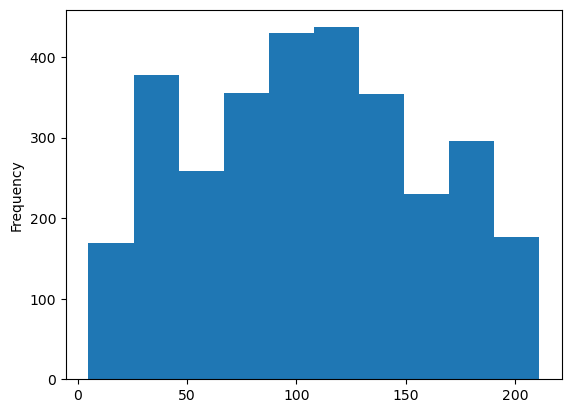

In [6]:
gwrf.weights.cardinalities.plot.hist()

Plot the local OOB score.

<Axes: >

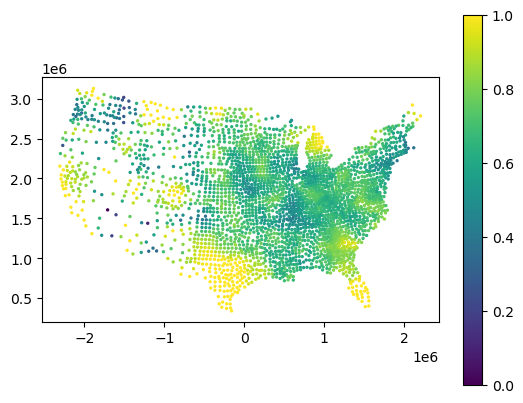

In [7]:
gdf.plot(gwrf.local_models.apply(lambda x: x.oob_score_), legend=True, s=2)